#### From SAV to LOVE

# HW №7

## Введение в обработку естественного языка
### Урок 7. Сверточные нейронные сети для анализа текста

### Практическое задание
### Задание из 2-х частей.
### Берем отызывы за лето (из архива с материалами или предыдущего занятия)

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install stop_words
!pip install pymorphy2

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [7]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Tensorflow with GPU

In [8]:
%tensorflow_version 2.x
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

def cpu():
    with tf.device('/cpu:0'):
        random_image_cpu = tf.random.normal((100, 100, 100, 3))
        net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
        return tf.math.reduce_sum(net_cpu)

def gpu():
    with tf.device('/device:GPU:0'):
        random_image_gpu = tf.random.normal((100, 100, 100, 3))
        net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
        return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup='from __main__ import cpu')
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup='from __main__ import gpu')
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.8300842999997258
GPU (s):
0.04033364499991876
GPU speedup over CPU: 70x


### Загрузка данных

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/my_projects/отзывы за лето.xls')

### Изучение датасета

In [11]:
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,"В целом удобноное приложение...из минусов хотят слишком большой доступ к персональным данным в телефоне,приходится пользоваться в ограниченном режиме",2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше никуда. Ранее больше года пользовался нормально.,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [12]:
df.tail()

,Rating,Content,Date
20654,1,"Ну и шляпа,с роот правами бесполезная прога,разрабы,вы чего охренеои что ли,зачем в приложении антивирус запихали,у людей свои стоят,испортили приложение👎👎👎",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01
20658,5,Сбербанк бомбовая компания на сегодняшний день. Лидер банков.!! Держитесь в том же духе.,2017-06-01


In [13]:
df.shape

(20659, 3)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [15]:
df.isnull().sum()

Rating     0
Content    3
Date       0
dtype: int64

### Предобработка

In [16]:
max_words = 200
max_len = 40
num_classes = 5

# Training
epochs = 20
batch_size = 64
print_batch_n = 100

In [17]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [18]:
def preprocess_reviews(reviews):
    reviews = str(reviews)
    reviews = ''.join(c for c in reviews if c not in exclude)
    reviews = reviews.lower()
    reviews = [morpher.parse(word)[0].normal_form for word in reviews.split() if word not in sw]
    reviews = " ".join(reviews)
    return reviews

In [19]:
df['Content'] = df['Content'].apply(preprocess_reviews)
df.head()

,Rating,Content,Date
0,5,it just works,2017-08-14
1,4,целое удобноной приложениеиз минус хотеть большой доступ персональный данные телефонеприходиться пользоваться ограниченный режим,2017-08-14
2,5,отлично,2017-08-14
3,5,зависать 1 работа антивирус ранее пользоваться нормально,2017-08-14
4,5,удобно работать быстро,2017-08-14


In [20]:
df.head()

,Rating,Content,Date
0,5,it just works,2017-08-14
1,4,целое удобноной приложениеиз минус хотеть большой доступ персональный данные телефонеприходиться пользоваться ограниченный режим,2017-08-14
2,5,отлично,2017-08-14
3,5,зависать 1 работа антивирус ранее пользоваться нормально,2017-08-14
4,5,удобно работать быстро,2017-08-14


In [21]:
unique_count_words = np.unique(np.array([len(word_tokenize(text)) for text in df['Content']]))

min_len = unique_count_words.min()
max_len = unique_count_words.max()
mean_len = round(unique_count_words.mean())
median_len = round(np.median(unique_count_words))
q25_len = round(np.quantile(unique_count_words, 0.25))
q75_len = round(np.quantile(unique_count_words, 0.75))

print(f'MIN: {min_len}'
      f'\nMAX: {max_len}'     
      f'\nMEAN: {mean_len}'
      f'\nMEDIAN: {median_len}'
      f'\nQUANTILE_25: {q25_len}'
      f'\nQUANTILE_75: {q75_len}')

MIN: 0
MAX: 132
MEAN: 40
MEDIAN: 36
QUANTILE_25: 18
QUANTILE_75: 55


### 0. Baseline

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], shuffle=True)

In [23]:
# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [74]:
models = []

models.append(('CountVectorizer_LR', CountVectorizer()))
models.append(('TfidfVectorizer_LR', TfidfVectorizer()))
models.append(('HashingVectorizer_LR', HashingVectorizer()))

In [75]:
# Logistic Regression
classifier = linear_model.LogisticRegression()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))
    
baseline_lr = pd.DataFrame(results, columns = ['model', 'train_accuracy', 'test_accuracy'])
baseline_lr.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy
1,TfidfVectorizer_LR,0.81528,0.77561
0,CountVectorizer_LR,0.88447,0.77367
2,HashingVectorizer_LR,0.80702,0.77231


In [76]:
models = []

models.append(('CountVectorizer_LSVC', CountVectorizer()))
models.append(('TfidfVectorizer_LSVC', TfidfVectorizer()))
models.append(('HashingVectorizer_LSVC', HashingVectorizer()))

In [77]:
# LinearSVC
classifier = LinearSVC()

results = []

for name, model in models:
    model.fit(X_train)
    X_train_count = model.transform(X_train)
    X_test_count = model.transform(X_test)
    
    classifier.fit(X_train_count, y_train)
    predictions_train = classifier.predict(X_train_count)
    predictions_test = classifier.predict(X_test_count)
    
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)

    results.append((name, train_accuracy, test_accuracy))
    
baseline_lsvc = pd.DataFrame(results, columns = ['model', 'train_accuracy', 'test_accuracy'])
baseline_lsvc.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy
2,HashingVectorizer_LSVC,0.89383,0.77173
1,TfidfVectorizer_LSVC,0.91300,0.76883
0,CountVectorizer_LSVC,0.92642,0.75741


### 1. Учим conv сеть для классификации

In [27]:
train_corpus = " ".join(X_train)
train_corpus[:100]

'обновление постоянно просить зарегистрироваться каждый вход устать регистрироваться смысл приложение'

In [28]:
tokens = word_tokenize(train_corpus)

print(len(tokens))
print(tokens[:5])

76427
['обновление', 'постоянно', 'просить', 'зарегистрироваться', 'каждый']


In [29]:
tokens_filtered = [word for word in tokens if word.isalnum()]

print(len(tokens_filtered))
print(tokens_filtered[:5])

75885
['обновление', 'постоянно', 'просить', 'зарегистрироваться', 'каждый']


In [30]:
dist = FreqDist(tokens_filtered)
token_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
token_filtered_top[:5]

['приложение', 'удобно', 'работать', 'удобный', 'отлично']

In [31]:
vocabulary = {v: k for k, v in dict(enumerate(token_filtered_top, 1)).items()}

In [32]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    padding = padding + result[-maxlen:]
    return padding

In [33]:
X_train_bow = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
X_test_bow = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [34]:
y_train_cat = utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes=num_classes)

In [35]:
model = Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Conv1D(filters=64, kernel_size=3),
    layers.MaxPool1D(pool_size=2),
    layers.Dropout(0.2), # Drop 20% of the units from the layer
   
    layers.GlobalAveragePooling1D(),
    layers.Dense(64),
    layers.Dropout(0.3), # Drop 30% of the units from the layer
    layers.Dense(num_classes, activation='softmax')
])

In [36]:
model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [37]:
%%time
history = model.fit(X_train_bow, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_test_bow, y_test_cat))

Epoch 1/20
243/243 [==============================] - 3s 8ms/step - loss: 1.0820 - accuracy: 0.6880 - val_loss: 0.8965 - val_accuracy: 0.7045
Epoch 2/20
243/243 [==============================] - 1s 5ms/step - loss: 0.8177 - accuracy: 0.7325 - val_loss: 0.8198 - val_accuracy: 0.7338
Epoch 3/20
243/243 [==============================] - 1s 5ms/step - loss: 0.7534 - accuracy: 0.7499 - val_loss: 0.7476 - val_accuracy: 0.7551
Epoch 4/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7304 - accuracy: 0.7551 - val_loss: 0.7391 - val_accuracy: 0.7473
Epoch 5/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7191 - accuracy: 0.7588 - val_loss: 0.7396 - val_accuracy: 0.7591
Epoch 6/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7213 - accuracy: 0.7551 - val_loss: 0.7224 - val_accuracy: 0.7561
Epoch 7/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7180 - accuracy: 0.7547 - val_loss: 0.7172 - val_accuracy: 0.7588
Epoch 

In [38]:
score_train = model.evaluate(X_train_bow, y_train_cat, verbose=0)
score_test = model.evaluate(X_test_bow, y_test_cat, verbose=0)

In [39]:
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

Train loss: 0.6570836901664734
Train accuracy: 0.7763004899024963
Test loss: 0.6987397074699402
Test accuracy: 0.7605034112930298


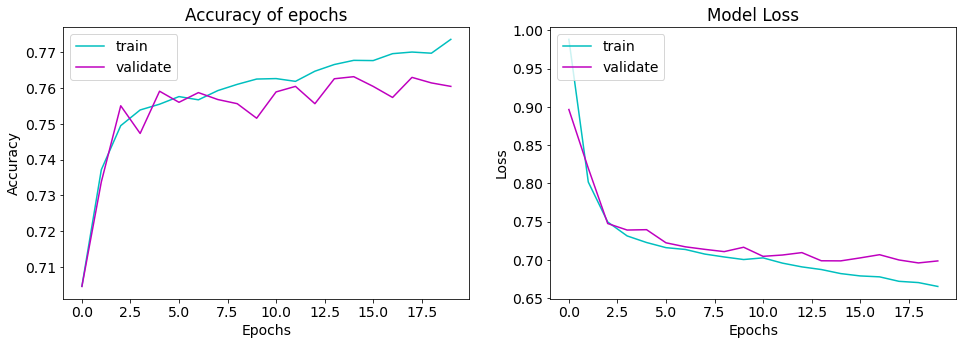

In [40]:
plot_model(history)

In [41]:
model_conv = pd.DataFrame((score_train[1], score_test[1], score_train[0], score_test[0])).T
model_conv.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
model_conv['model'] = 'model_conv'

### 2. Берём предобученный word2vec и его эмбедингами инициализируем сетку, как влияет на качество?

In [42]:
import gensim.downloader as api
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [43]:
wv = api.load('glove-twitter-25')

In [44]:
def text_to_w2v(text, maxlen):
    result = []
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum()]
    for w in words:
        if w in wv:
            result.append(list(wv[w]))
    padding = [[0]*25]*(maxlen-len(result))
    result = padding + result[-maxlen:]
    return result

In [45]:
X_train_w2v = np.array([text_to_w2v(text, max_len) for text in X_train])
X_test_w2v = np.array([text_to_w2v(text, max_len) for text in X_test])

print(X_train_w2v.shape)
print(X_test_w2v.shape)

(15494, 132, 25)
(5165, 132, 25)


In [46]:
model_word2vec = Sequential([
    layers.Conv1D(filters=128, kernel_size=3),
    layers.MaxPool1D(pool_size=2),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    layers.Dense(10),
    layers.Activation('relu'),
    
    layers.Dropout(0.15), # Drop 30% of the units from the layer
    layers.Dense(num_classes),
    layers.Activation('softmax')
])

model_word2vec.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [47]:
model_word2vec.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [48]:
%%time
history_2 = model_word2vec.fit(X_train_w2v, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_test_w2v, y_test_cat))

Epoch 1/20
243/243 [==============================] - 2s 7ms/step - loss: 0.9918 - accuracy: 0.6733 - val_loss: 0.7581 - val_accuracy: 0.7040
Epoch 2/20
243/243 [==============================] - 1s 4ms/step - loss: 0.7381 - accuracy: 0.7331 - val_loss: 0.7204 - val_accuracy: 0.7417
Epoch 3/20
243/243 [==============================] - 1s 4ms/step - loss: 0.7168 - accuracy: 0.7527 - val_loss: 0.7009 - val_accuracy: 0.7526
Epoch 4/20
243/243 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.7571 - val_loss: 0.6896 - val_accuracy: 0.7547
Epoch 5/20
243/243 [==============================] - 1s 4ms/step - loss: 0.6753 - accuracy: 0.7628 - val_loss: 0.6819 - val_accuracy: 0.7574
Epoch 6/20
243/243 [==============================] - 1s 4ms/step - loss: 0.6602 - accuracy: 0.7692 - val_loss: 0.6866 - val_accuracy: 0.7526
Epoch 7/20
243/243 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.7696 - val_loss: 0.6841 - val_accuracy: 0.7578
Epoch 

In [49]:
score_train_2 = model_word2vec.evaluate(X_train_w2v, y_train_cat, verbose=0)
score_test_2 = model_word2vec.evaluate(X_test_w2v, y_test_cat, verbose=0)

In [50]:
print('Train loss:', score_train_2[0])
print('Train accuracy:', score_train_2[1])
print('Test loss:', score_test_2[0])
print('Test accuracy:', score_test_2[1])

Train loss: 0.494904100894928
Train accuracy: 0.8176713585853577
Test loss: 0.7570669651031494
Test accuracy: 0.7502419948577881


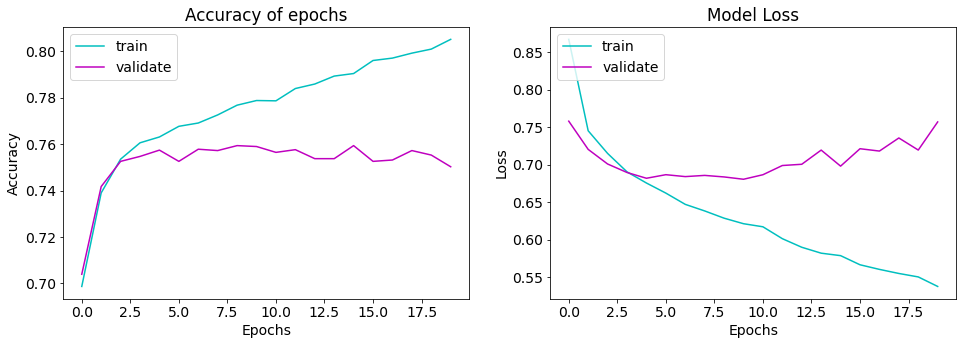

In [51]:
plot_model(history_2)

In [52]:
model_word2vec = pd.DataFrame((score_train_2[1], score_test_2[1], score_train_2[0], score_test_2[0])).T
model_word2vec.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
model_word2vec['model'] = 'model_word2vec'

### 3. Сравнить разные виды эмбедингов tf.Embeddings word2vec/Fasttext (в качестве агригации попробовать разные виды не только среднее для документа)

In [53]:
values = []

values.append(('MIN', min_len))
values.append(('MAX', max_len))
values.append(('MEAN', mean_len))
values.append(('MEDIAN', median_len))
values.append(('QUANTILE_25', q25_len))
values.append(('QUANTILE_75', q25_len))

Epoch 1/20
243/243 [==============================] - 2s 6ms/step - loss: 1.0612 - accuracy: 0.6913 - val_loss: 0.9013 - val_accuracy: 0.7055
Epoch 2/20
243/243 [==============================] - 1s 5ms/step - loss: 0.8340 - accuracy: 0.7266 - val_loss: 0.7651 - val_accuracy: 0.7429
Epoch 3/20
243/243 [==============================] - 1s 5ms/step - loss: 0.7458 - accuracy: 0.7495 - val_loss: 0.7432 - val_accuracy: 0.7466
Epoch 4/20
243/243 [==============================] - 1s 5ms/step - loss: 0.7474 - accuracy: 0.7465 - val_loss: 0.7427 - val_accuracy: 0.7491
Epoch 5/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7313 - accuracy: 0.7546 - val_loss: 0.7445 - val_accuracy: 0.7458
Epoch 6/20
243/243 [==============================] - 1s 5ms/step - loss: 0.7343 - accuracy: 0.7514 - val_loss: 0.7216 - val_accuracy: 0.7516
Epoch 7/20
243/243 [==============================] - 1s 5ms/step - loss: 0.7097 - accuracy: 0.7566 - val_loss: 0.7175 - val_accuracy: 0.7555
Epoch 

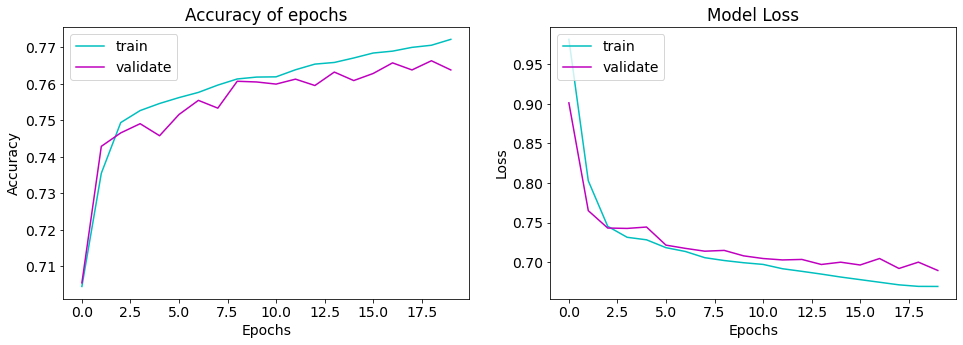

Epoch 1/20
243/243 [==============================] - 2s 7ms/step - loss: 1.0715 - accuracy: 0.6974 - val_loss: 0.9045 - val_accuracy: 0.7038
Epoch 2/20
243/243 [==============================] - 1s 6ms/step - loss: 0.8519 - accuracy: 0.7203 - val_loss: 0.7760 - val_accuracy: 0.7479
Epoch 3/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7676 - accuracy: 0.7450 - val_loss: 0.7450 - val_accuracy: 0.7448
Epoch 4/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7302 - accuracy: 0.7537 - val_loss: 0.7333 - val_accuracy: 0.7491
Epoch 5/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7085 - accuracy: 0.7600 - val_loss: 0.7258 - val_accuracy: 0.7508
Epoch 6/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7096 - accuracy: 0.7599 - val_loss: 0.7227 - val_accuracy: 0.7528
Epoch 7/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7212 - accuracy: 0.7544 - val_loss: 0.7172 - val_accuracy: 0.7599
Epoch 

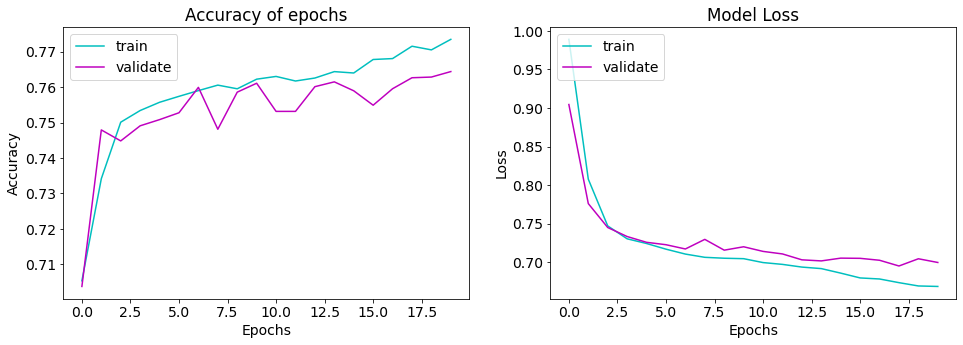

Epoch 1/20
243/243 [==============================] - 2s 6ms/step - loss: 1.0713 - accuracy: 0.7041 - val_loss: 0.8890 - val_accuracy: 0.7075
Epoch 2/20
243/243 [==============================] - 1s 6ms/step - loss: 0.8405 - accuracy: 0.7237 - val_loss: 0.7660 - val_accuracy: 0.7440
Epoch 3/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7642 - accuracy: 0.7465 - val_loss: 0.7460 - val_accuracy: 0.7464
Epoch 4/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7325 - accuracy: 0.7525 - val_loss: 0.7386 - val_accuracy: 0.7535
Epoch 5/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7282 - accuracy: 0.7513 - val_loss: 0.7312 - val_accuracy: 0.7526
Epoch 6/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7239 - accuracy: 0.7543 - val_loss: 0.7278 - val_accuracy: 0.7570
Epoch 7/20
243/243 [==============================] - 2s 6ms/step - loss: 0.7165 - accuracy: 0.7538 - val_loss: 0.7266 - val_accuracy: 0.7508
Epoch 

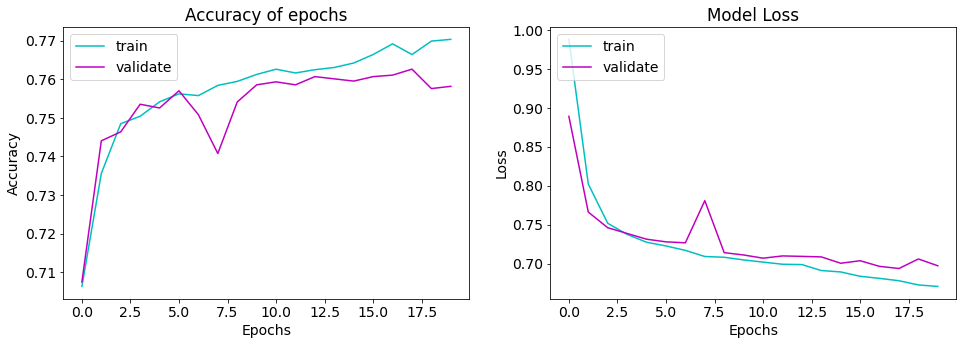

Epoch 1/20
243/243 [==============================] - 2s 7ms/step - loss: 1.0838 - accuracy: 0.7048 - val_loss: 0.9054 - val_accuracy: 0.7036
Epoch 2/20
243/243 [==============================] - 1s 6ms/step - loss: 0.8399 - accuracy: 0.7298 - val_loss: 0.7684 - val_accuracy: 0.7425
Epoch 3/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7457 - accuracy: 0.7485 - val_loss: 0.7510 - val_accuracy: 0.7439
Epoch 4/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7382 - accuracy: 0.7482 - val_loss: 0.7514 - val_accuracy: 0.7450
Epoch 5/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7403 - accuracy: 0.7484 - val_loss: 0.7371 - val_accuracy: 0.7479
Epoch 6/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7152 - accuracy: 0.7580 - val_loss: 0.7380 - val_accuracy: 0.7584
Epoch 7/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7188 - accuracy: 0.7565 - val_loss: 0.7167 - val_accuracy: 0.7553
Epoch 

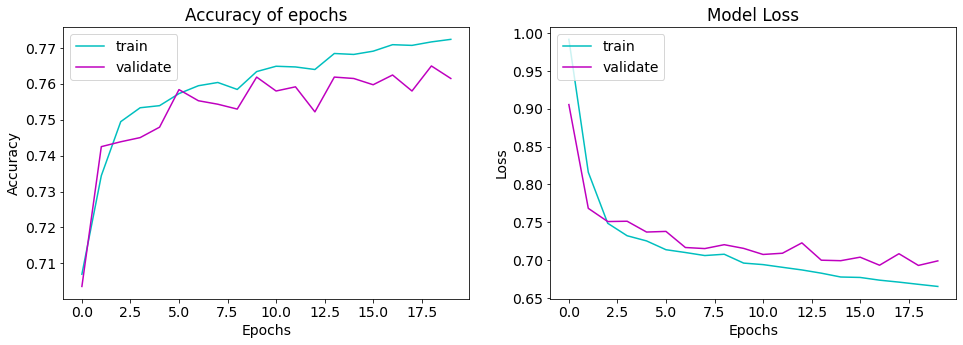

Epoch 1/20
243/243 [==============================] - 2s 7ms/step - loss: 1.0740 - accuracy: 0.6972 - val_loss: 0.8914 - val_accuracy: 0.7080
Epoch 2/20
243/243 [==============================] - 1s 6ms/step - loss: 0.8349 - accuracy: 0.7262 - val_loss: 0.7839 - val_accuracy: 0.7493
Epoch 3/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7496 - accuracy: 0.7525 - val_loss: 0.7454 - val_accuracy: 0.7541
Epoch 4/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7456 - accuracy: 0.7489 - val_loss: 0.7297 - val_accuracy: 0.7526
Epoch 5/20
243/243 [==============================] - 2s 6ms/step - loss: 0.7157 - accuracy: 0.7573 - val_loss: 0.7272 - val_accuracy: 0.7590
Epoch 6/20
243/243 [==============================] - 2s 6ms/step - loss: 0.7200 - accuracy: 0.7561 - val_loss: 0.7246 - val_accuracy: 0.7518
Epoch 7/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7107 - accuracy: 0.7550 - val_loss: 0.7308 - val_accuracy: 0.7601
Epoch 

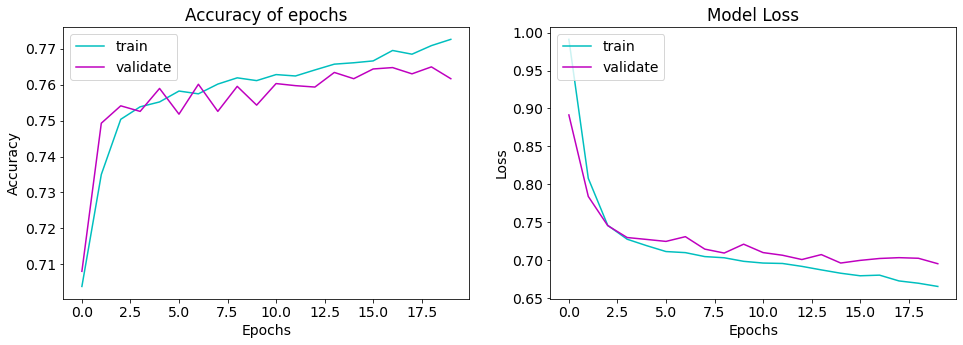

Epoch 1/20
243/243 [==============================] - 2s 7ms/step - loss: 1.0899 - accuracy: 0.6851 - val_loss: 0.8910 - val_accuracy: 0.7053
Epoch 2/20
243/243 [==============================] - 2s 6ms/step - loss: 0.8411 - accuracy: 0.7243 - val_loss: 0.7677 - val_accuracy: 0.7458
Epoch 3/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7530 - accuracy: 0.7516 - val_loss: 0.8049 - val_accuracy: 0.7353
Epoch 4/20
243/243 [==============================] - 2s 6ms/step - loss: 0.7308 - accuracy: 0.7533 - val_loss: 0.7349 - val_accuracy: 0.7518
Epoch 5/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7162 - accuracy: 0.7563 - val_loss: 0.7297 - val_accuracy: 0.7535
Epoch 6/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7142 - accuracy: 0.7588 - val_loss: 0.7275 - val_accuracy: 0.7570
Epoch 7/20
243/243 [==============================] - 1s 6ms/step - loss: 0.7174 - accuracy: 0.7563 - val_loss: 0.7199 - val_accuracy: 0.7535
Epoch 

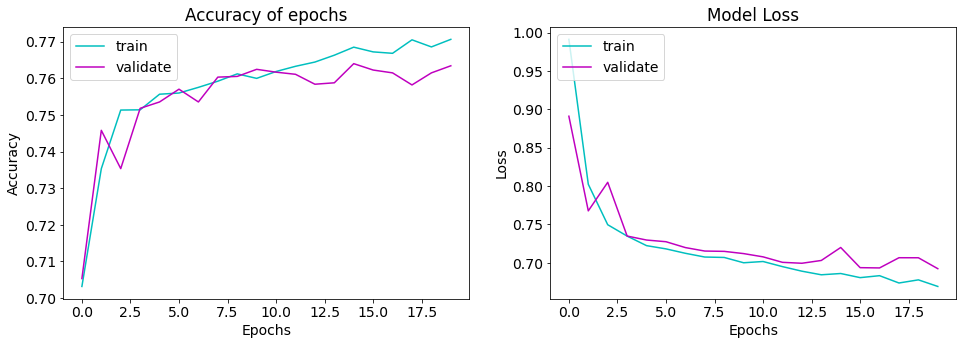

In [54]:
# tensorflow
results = []
historys = []

for name, val in values:
    model = Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=val),
    layers.Conv1D(filters=64, kernel_size=3),
    layers.MaxPool1D(pool_size=2),
    layers.Dropout(0.2), # Drop 20% of the units from the layer
   
    layers.GlobalAveragePooling1D(),
    layers.Dense(64),
    layers.Dropout(0.3), # Drop 30% of the units from the layer
    layers.Dense(num_classes, activation='softmax')])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_bow, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_test_bow, y_test_cat))

    score_train = model.evaluate(X_train_bow, y_train_cat, verbose=0)
    score_test = model.evaluate(X_test_bow, y_test_cat, verbose=0)

    train_loss = score_train[0]
    train_accuracy = score_train[1]
    test_loss = score_test[0]
    test_accuracy = score_test[1]

    plot_model(history)
    historys.append((history))
    results.append((name, train_accuracy, test_accuracy, train_loss, test_loss))

In [55]:
best_values = pd.DataFrame(results, columns = ['model', 'train_accuracy', 'test_accuracy', 'train_loss', 'test_loss'])
best_values.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,train_loss,test_loss
1,MAX,0.77701,0.76438,0.65712,0.69966
0,MIN,0.77830,0.76379,0.65595,0.68963
5,QUANTILE_75,0.77443,0.76341,0.65311,0.69241
4,QUANTILE_25,0.77507,0.76167,0.65564,0.69515
3,MEDIAN,0.77346,0.76147,0.65470,0.69908
2,MEAN,0.77030,0.75818,0.65946,0.69708


### 4. По моделировать различные архитектуры сетей (несколько слоёв свёрток с пулингом без с полносвязанными и без них) по смотреть какая архитектура быстрее переобучается, какая более хорошо решает текущую задачу

**Increased layers and Filters along with Increased dropout**

In [56]:
model_3 = Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Conv1D(filters=32, kernel_size=3, kernel_initializer='he_uniform', padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=2),
    layers.Dropout(0.2), # Drop 20% of the units from the layer
   
    layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_uniform', padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_uniform', padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=2),
    Dropout(0.25), # Drop 25% of the units from the layer

    Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    layers.Dropout(0.3), # Drop 30% of the units from the layer
    layers.Dense(num_classes, activation='softmax')
])

In [57]:
model_3.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [58]:
%%time
history_3 = model_3.fit(X_train_bow, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_test_bow, y_test_cat))

Epoch 1/20
243/243 [==============================] - 3s 9ms/step - loss: 0.9258 - accuracy: 0.7121 - val_loss: 0.7058 - val_accuracy: 0.7580
Epoch 2/20
243/243 [==============================] - 1s 6ms/step - loss: 0.6995 - accuracy: 0.7608 - val_loss: 0.7223 - val_accuracy: 0.7566
Epoch 3/20
243/243 [==============================] - 2s 6ms/step - loss: 0.6860 - accuracy: 0.7681 - val_loss: 0.6979 - val_accuracy: 0.7584
Epoch 4/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6691 - accuracy: 0.7727 - val_loss: 0.6779 - val_accuracy: 0.7653
Epoch 5/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6705 - accuracy: 0.7709 - val_loss: 0.6850 - val_accuracy: 0.7644
Epoch 6/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6516 - accuracy: 0.7754 - val_loss: 0.6764 - val_accuracy: 0.7702
Epoch 7/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6418 - accuracy: 0.7776 - val_loss: 0.6744 - val_accuracy: 0.7675
Epoch 

In [59]:
score_train_3 = model_3.evaluate(X_train_bow, y_train_cat, verbose=0)
score_test_3 = model_3.evaluate(X_test_bow, y_test_cat, verbose=0)

In [60]:
print('Train loss:', score_train_3[0])
print('Train accuracy:', score_train_3[1])
print('Test loss:', score_test_3[0])
print('Test accuracy:', score_test_3[1])

Train loss: 0.5473727583885193
Train accuracy: 0.8132179975509644
Test loss: 0.7178981900215149
Test accuracy: 0.7558567523956299


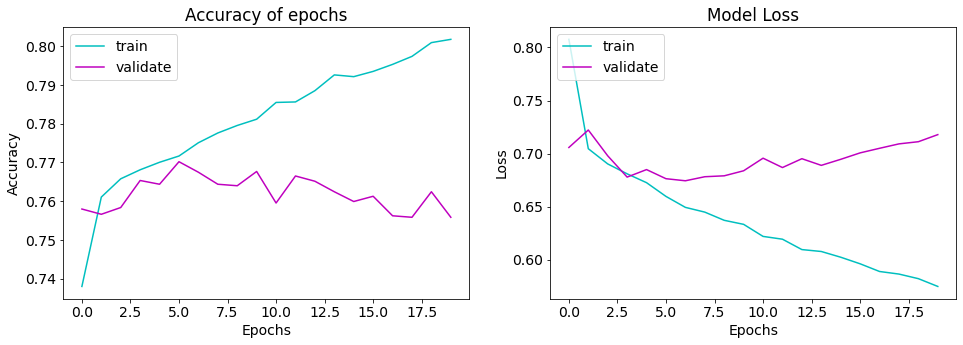

In [61]:
plot_model(history_3)

In [62]:
model_3 = pd.DataFrame((score_train_3[1], score_test_3[1], score_train_3[0], score_test_3[0])).T
model_3.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
model_3['model'] = 'Increased layers and Filters'

**Adding SeparableConv1D**

In [63]:
model_4 = Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.SeparableConv1D(filters=32, kernel_size=3, kernel_initializer='he_uniform', padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=2),
    layers.Dropout(0.2), # Drop 20% of the units from the layer
   
    layers.SeparableConv1D(filters=64, kernel_size=3, kernel_initializer='he_uniform', padding='same', activation='relu'),
    layers.SeparableConv1D(filters=64, kernel_size=3, kernel_initializer='he_uniform', padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=2),
    Dropout(0.25), # Drop 25% of the units from the layer

    Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    layers.Dropout(0.3), # Drop 30% of the units from the layer
    layers.Dense(num_classes, activation='softmax')
])

In [64]:
model_4.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [65]:
%%time
history_4 = model_4.fit(X_train_bow, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_test_bow, y_test_cat))

Epoch 1/20
243/243 [==============================] - 4s 10ms/step - loss: 1.1072 - accuracy: 0.6963 - val_loss: 0.7257 - val_accuracy: 0.7473
Epoch 2/20
243/243 [==============================] - 2s 7ms/step - loss: 0.7294 - accuracy: 0.7544 - val_loss: 0.6950 - val_accuracy: 0.7576
Epoch 3/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6975 - accuracy: 0.7598 - val_loss: 0.6921 - val_accuracy: 0.7603
Epoch 4/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6898 - accuracy: 0.7609 - val_loss: 0.6875 - val_accuracy: 0.7613
Epoch 5/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6772 - accuracy: 0.7682 - val_loss: 0.6866 - val_accuracy: 0.7642
Epoch 6/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6822 - accuracy: 0.7645 - val_loss: 0.6836 - val_accuracy: 0.7650
Epoch 7/20
243/243 [==============================] - 2s 7ms/step - loss: 0.6716 - accuracy: 0.7686 - val_loss: 0.6837 - val_accuracy: 0.7636
Epoch

In [66]:
score_train_4 = model_4.evaluate(X_train_bow, y_train_cat, verbose=0)
score_test_4 = model_4.evaluate(X_test_bow, y_test_cat, verbose=0)

In [67]:
print('Train loss:', score_train_4[0])
print('Train accuracy:', score_train_4[1])
print('Test loss:', score_test_4[0])
print('Test accuracy:', score_test_4[1])

Train loss: 0.623085618019104
Train accuracy: 0.7823028564453125
Test loss: 0.6820528507232666
Test accuracy: 0.7674733996391296


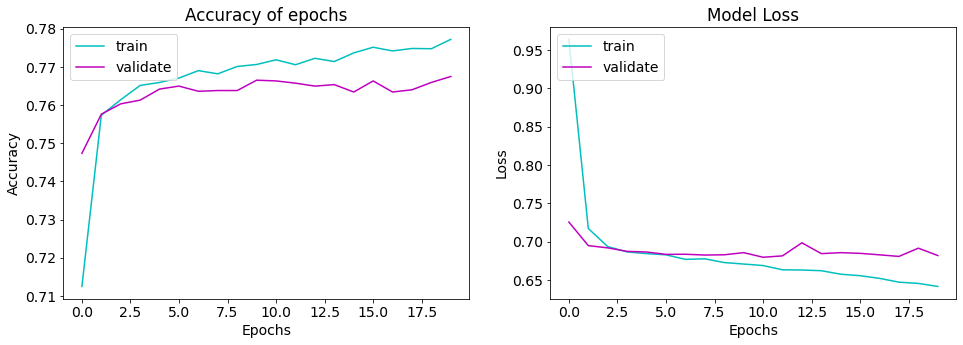

In [68]:
plot_model(history_4)

In [69]:
model_4 = pd.DataFrame((score_train_4[1], score_test_4[1], score_train_4[0], score_test_4[0])).T
model_4.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
model_4['model'] = 'Adding SeparableConv1D'

### Results

In [78]:
final_results = pd.concat([baseline_lr, baseline_lsvc, model_conv, model_word2vec, best_values, model_3, model_4], axis=0)

In [79]:
final_results.sort_values('test_accuracy', ascending=False)

,model,train_accuracy,test_accuracy,train_loss,test_loss
1,TfidfVectorizer_LR,0.81528,0.77561,nan,nan
0,CountVectorizer_LR,0.88447,0.77367,nan,nan
2,HashingVectorizer_LR,0.80702,0.77231,nan,nan
2,HashingVectorizer_LSVC,0.89383,0.77173,nan,nan
1,TfidfVectorizer_LSVC,0.91300,0.76883,nan,nan
0,Adding SeparableConv1D,0.78230,0.76747,0.62309,0.68205
1,MAX,0.77701,0.76438,0.65712,0.69966
0,MIN,0.77830,0.76379,0.65595,0.68963
5,QUANTILE_75,0.77443,0.76341,0.65311,0.69241
4,QUANTILE_25,0.77507,0.76167,0.65564,0.69515


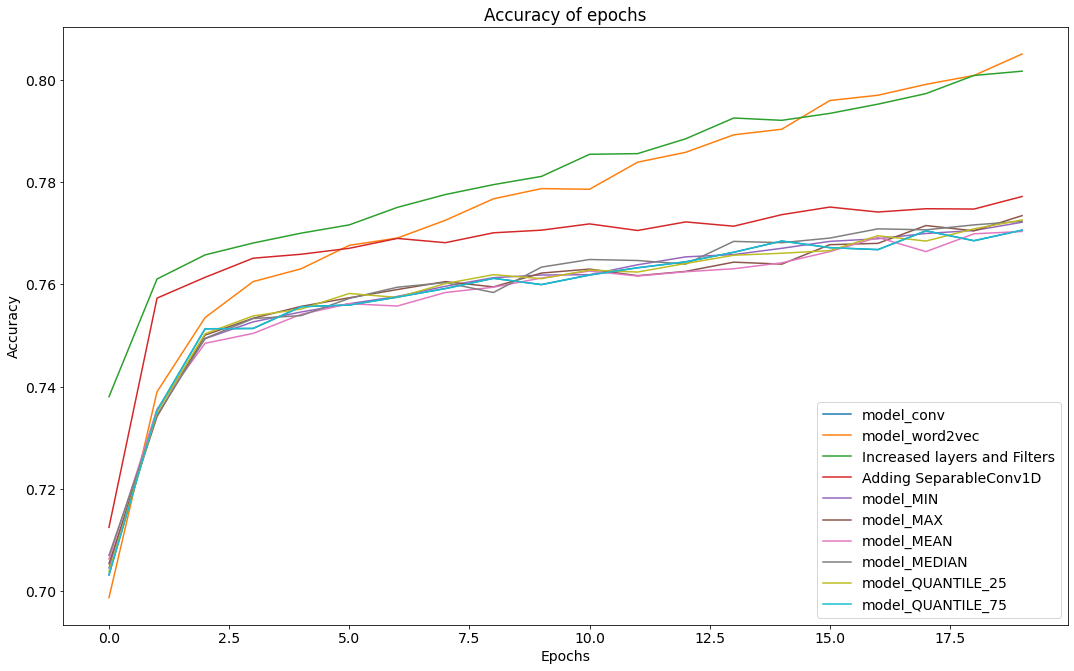

In [72]:
plt.figure(figsize=(18, 11))
plt.plot(history.history['accuracy'], label='model_conv')
plt.plot(history_2.history['accuracy'], label='model_word2vec')
plt.plot(history_3.history['accuracy'], label='Increased layers and Filters')
plt.plot(history_4.history['accuracy'], label='Adding SeparableConv1D')
plt.plot(historys[0].history['accuracy'], label='model_MIN')
plt.plot(historys[1].history['accuracy'], label='model_MAX')
plt.plot(historys[2].history['accuracy'], label='model_MEAN')
plt.plot(historys[3].history['accuracy'], label='model_MEDIAN')
plt.plot(historys[4].history['accuracy'], label='model_QUANTILE_25')
plt.plot(historys[5].history['accuracy'], label='model_QUANTILE_75')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of epochs')
plt.show()

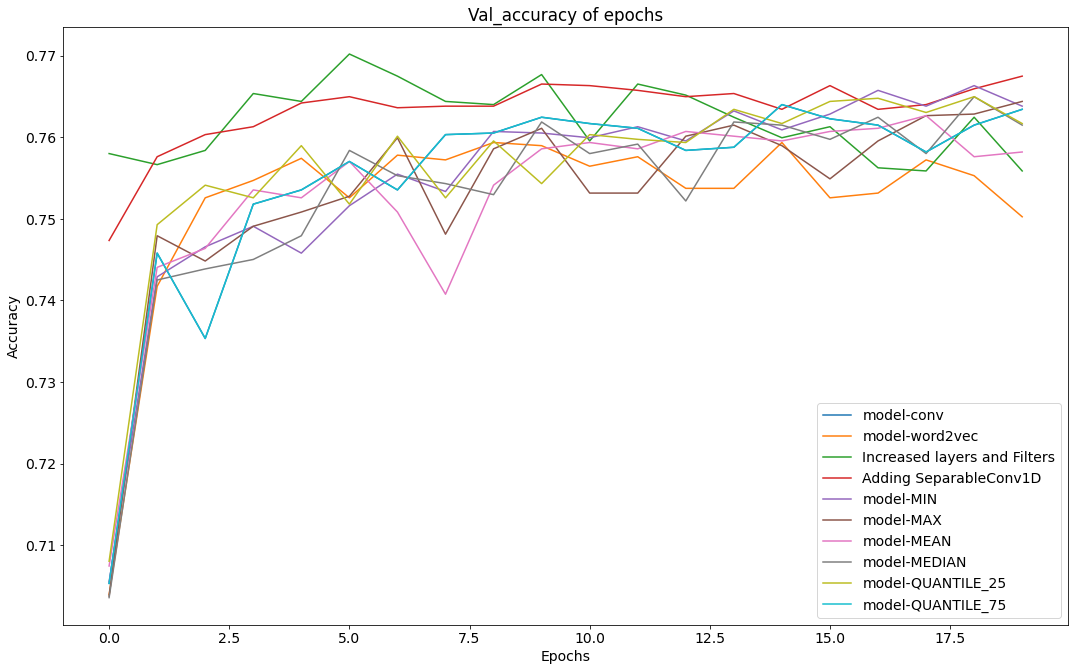

In [73]:
plt.figure(figsize=(18, 11))
plt.plot(history.history['val_accuracy'], label='model-conv')
plt.plot(history_2.history['val_accuracy'], label='model-word2vec')
plt.plot(history_3.history['val_accuracy'], label='Increased layers and Filters')
plt.plot(history_4.history['val_accuracy'], label='Adding SeparableConv1D')
plt.plot(historys[0].history['val_accuracy'], label='model-MIN')
plt.plot(historys[1].history['val_accuracy'], label='model-MAX')
plt.plot(historys[2].history['val_accuracy'], label='model-MEAN')
plt.plot(historys[3].history['val_accuracy'], label='model-MEDIAN')
plt.plot(historys[4].history['val_accuracy'], label='model-QUANTILE_25')
plt.plot(historys[5].history['val_accuracy'], label='model-QUANTILE_75')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Val_accuracy of epochs')
plt.show()